In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
all_data = pd.read_csv('all_data_see_docs.csv')
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

train.shape, test.shape, all_data.shape, train_ID.shape, test_ID.shape, y_train.shape

((1458, 80), (1459, 79), (2917, 79), (1460,), (1459,), (1458,))

## Things, we need to proceed

In [2]:
all_data.shape, train_ID.shape, test_ID.shape, y_train.shape

((2917, 79), (1460,), (1459,), (1458,))

In [3]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)


(2917, 220)


In [4]:
train = all_data[:ntrain]
test = all_data[ntrain:]
train.shape, test.shape

((1458, 220), (1459, 220))

## Start modelling

### from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone


In [5]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
# from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [6]:
n_folds = 5
kf = KFold(n_folds, shuffle=True, random_state=42)#.get_n_splits(train.values)
print("no of splits: ",kf.get_n_splits(train.values))

for train_idx, test_idx in kf.split(train.values):
    print(train_idx.shape, test_idx.shape)

no of splits:  5
(1166,) (292,)
(1166,) (292,)
(1166,) (292,)
(1167,) (291,)
(1167,) (291,)


In [7]:
#Define a cross validation strategy
#We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, 
#we add then one line of code, in order to shuffle the dataset prior to cross-validation

#Validation function
n_folds = 3

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


In [8]:
#Base models

#    LASSO Regression :
#This model may be very sensitive to outliers. So we need to made it more robust on them. 
#For that we use the sklearn's Robustscaler() method on pipeline

# lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso = Lasso(alpha =0.0005, random_state=1)

#    Elastic Net Regression :
#again made robust to outliers

# ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)

#    Kernel Ridge Regression :
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#    Gradient Boosting Regression :
#With huber loss that makes it robust to outliers
GBoost = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,#n_estimators=3000
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

#    XGBoost :
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=220,#n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

#    LightGBM :
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=220,#n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)



In [10]:
all_models = [lasso, ENet, KRR, GBoost, model_xgb, model_lgb]
all_models_name = ['lasso', 'ENet', 'KRR', 'GBoost', 'model_xgb', 'model_lgb']

i = 0
for model in all_models:
    score = rmsle_cv(model)
    print("{} score: {:.4f} ({:.4f})".format(all_models_name[i], score.mean(), score.std()))
    i += 1


lasso score: 0.1146 (0.0075)
ENet score: 0.1146 (0.0075)
KRR score: 0.1163 (0.0067)
GBoost score: 0.1194 (0.0101)
model_xgb score: 0.1248 (0.0079)
model_lgb score: 0.1209 (0.0079)


In [24]:
# Simplest Stacking approach : Averaging base models

# We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn 
# with our model and also to laverage encapsulation and code reuse (inheritance)

# Averaged base models class

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   



In [25]:
# Averaged base models score

# We just average four models here ENet, GBoost, KRR and lasso. Of course we could easily add 
# more models in the mix.

averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



 Averaged base models score: 0.1112 (0.0083)



In [28]:
averaged_models

AveragingModels(models=(ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=3, selection='cyclic', tol=0.0001, warm_start=False), GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
 ...itive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)))

In [29]:
score

array([0.10609078, 0.12285565, 0.10463087])

In [31]:
[list() for x in all_models]

[[], [], [], [], [], []]

In [45]:
import multiprocessing
multiprocessing.cpu_count()

4

In [35]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        # create emply list to store each model, with their own copies for each splits
        # Now: [[], [], []]
        # After filling all model, it will looks like following
        #   For these three model: ENet, KRR, lasso
        #  [[ENet_0,     ENet_1,    ENet_2], 
        #   [KRR_0,      KRR_1,     KRR_2], 
        #   [lasso_0,    lasso_1,   lasso_2] ]
        self.base_models_ = [list() for x in self.base_models]
        # cloning keeps a copy of the model, wth no data stored in them
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                #
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                # valid_sets = [trn_data, val_data], 
#                     verbose_eval=1000, early_stopping_rounds = 250
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])        
#         meta_features_data = np.column_stack([
#             np.column_stack([model.predict(X) for model in base_models])
#             for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

    def predict_mine(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])        
#         meta_features_data = np.column_stack([
#             np.column_stack([model.predict(X) for model in base_models])
#             for base_models in self.base_models_ ])
        
#         if base_models_name is not None:
#             meta_features = pd.DataFrame(data=meta_features, columns=base_models_name)
#         else:
#             meta_features = pd.DataFrame(data=meta_features)
        meta_features = pd.DataFrame(data=meta_features)
        meta_features.to_csv('meta_features.csv', index=None)
        print("saved meta-features")
        return self.meta_model_.predict(meta_features)


In [36]:
# Stacking Averaged models Score

# To make the two approaches comparable (by using the same number of models) , 
# we just average Enet KRR and Gboost, then we add lasso as meta-model.

stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso,
                                                 n_folds = 3)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))



Stacking Averaged models score: 0.1104 (0.0082)


In [37]:
score

array([0.10588287, 0.12196343, 0.10348434])

In [13]:
# Ensembling StackedRegressor, XGBoost and LightGBM

# We add XGBoost and LightGBM to the StackedRegressor defined previously.

# We first define a rmsle evaluation function

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


In [43]:
# Final Training and Prediction

# StackedRegressor:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, model_xgb),
                                                 meta_model =  (model_lgb))
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))



0.0988124092752


In [37]:
temp2 = stacked_averaged_models.predict_mine(train.values)


saved meta-features


In [17]:
temp1.shape, train.shape

((1458, 3), (1458, 220))

In [49]:
# XGBoost:

model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))


0.09800476614098601


In [50]:
#LightGBM:

model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))


0.09694904136731106


In [51]:
#'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))



RMSLE score on train data:
0.08917172385279482


In [52]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

(0, 800000)

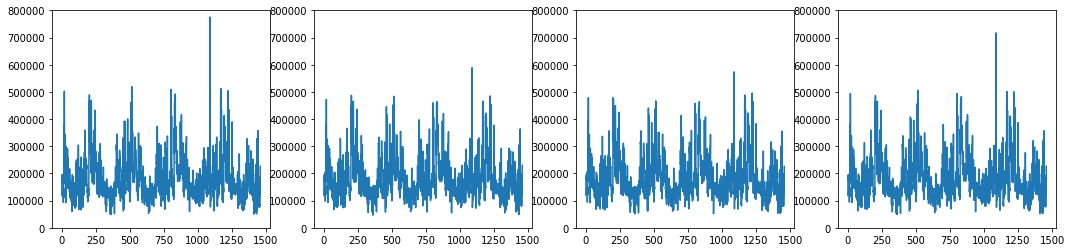

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1,4, figsize=(18,4))
ax[0].plot(stacked_pred)
ax[0].set_ylim([0,800000])
ax[1].plot(xgb_pred)
ax[1].set_ylim([0,800000])
ax[2].plot(lgb_pred)
ax[2].set_ylim([0,800000])
ax[3].plot(ensemble)
ax[3].set_ylim([0,800000])


## experiment

In [18]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        # create emply list to store each model, with their own copies for each splits
        # Now: [[], [], []]
        # After filling all model, it will looks like following
        #   For these three model: ENet, KRR, lasso
        #  [[ENet_0,     ENet_1,    ENet_2], 
        #   [KRR_0,      KRR_1,     KRR_2], 
        #   [lasso_0,    lasso_1,   lasso_2] ]
        self.base_models_ = [list() for x in self.base_models]
        # cloning keeps a copy of the model, wth no data stored in them
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                #
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])        
        meta_features_data = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models])
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)


In [19]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

In [20]:
n_folds=3
kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
cross_val_score(stacked_averaged_models, train.values, y_train, scoring="neg_mean_squared_error", cv = kf)


array([-0.01120774, -0.01487488, -0.01070884])